<a href="https://colab.research.google.com/github/Guillem96/activity-recognition/blob/master/notebooks/Visualizing%20what%203D%20CNN%20learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing what a 3D Convnet learns

Inspired by the [C3D paper](https://arxiv.org/pdf/1412.0767.pdf) explanations, we decided to further explore how to explain the 3D CNN predictions. To do so we implement the algorithm described in [here](https://arxiv.org/abs/1412.6806).

With these simple visualization, we will be able to dictaminate which are the more relevant parts of the video when performing a classification.

In [18]:
!wget https://yt-dl.org/downloads/latest/youtube-dl -O /usr/local/bin/youtube-dl
!chmod a+rx /usr/local/bin/youtube-dl
!youtube-dl -f160 http://youtube.com/watch?v=-05APhKiIXc
!pip install av

--2020-07-13 14:26:42--  https://yt-dl.org/downloads/latest/youtube-dl
Resolving yt-dl.org (yt-dl.org)... 95.143.172.170, 2001:1a50:11:0:5f:8f:acaa:177
Connecting to yt-dl.org (yt-dl.org)|95.143.172.170|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://yt-dl.org/downloads/2020.06.16.1/youtube-dl [following]
--2020-07-13 14:26:42--  https://yt-dl.org/downloads/2020.06.16.1/youtube-dl
Connecting to yt-dl.org (yt-dl.org)|95.143.172.170|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ytdl-org/youtube-dl/releases/download/2020.06.16.1/youtube-dl [following]
--2020-07-13 14:26:42--  https://github.com/ytdl-org/youtube-dl/releases/download/2020.06.16.1/youtube-dl
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github-production-release-asset-2e65be.s3.amazonaws.com/1039

In [21]:
#@markdown `import *`
from base64 import b64encode
from IPython.display import HTML

from PIL import Image
import numpy as np

import torch
import torchvision.io as io
import torchvision.models as zoo
import torchvision.transforms as T

import matplotlib.pyplot as plt

In [22]:
#@markdown Video transforms

def resize(vid, size, interpolation='bilinear'):
    scale = None
    if isinstance(size, int):
        scale = float(size) / min(vid.shape[-2:])
        size = None
    return torch.nn.functional.interpolate(
        vid, size=size, scale_factor=scale, mode=interpolation, align_corners=False)

def to_normalized_float_tensor(vid):
    return vid.permute(3, 0, 1, 2).to(torch.float32) / 255

def normalize(vid, mean, std):
    shape = (-1,) + (1,) * (vid.dim() - 1)
    mean = torch.as_tensor(mean).reshape(shape)
    std = torch.as_tensor(std).reshape(shape)
    return (vid - mean) / std

def tfms(vid):
    vid = to_normalized_float_tensor(vid)
    vid = resize(vid, (112, 112))
    return normalize(vid, 
                     mean=[0.485, 0.456, 0.406], 
                     std=[0.229, 0.224, 0.225])


In [41]:
#@markdown Display Video Function
def display_video(video, title=''):
    from matplotlib import animation
    from IPython.display import HTML, display

    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(video[0,:,:,:])

    plt.close() # this is required to not display the generated image

    def init():
        im.set_data(video[0,:,:,:])

    def animate(i):
        im.set_data(video[i,:,:,:])
        return im

    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=video.shape[0], interval=50)
    display(HTML(f"<h1>{title}</h1>" + anim.to_html5_video()))

def display_video_f(fname):
    mp4 = open(fname,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url))

In [42]:
display_video_f('/content/Chipping 10 Yards - Golf Lessons Orange County CA--05APhKiIXc.mp4')

In [25]:
video_original, audio, info = io.read_video(
    'Chipping 10 Yards - Golf Lessons Orange County CA--05APhKiIXc.mp4',
    start_pts=80,
    end_pts=90,
    pts_unit='sec')

rand_idx = torch.randint(0, high=video_original.size(0) - 16, size=(1,)).item()
clip = video_original[rand_idx:rand_idx + 16]
video_t = tfms(clip)

In [26]:
display_video(clip)

In [27]:
def post_process_grad_im(im):
    im = im - im.min()
    im /= im.max()
    return to_np_im(im)

def to_np_im(im):
    return (im.transpose(1, 2, 0) * 255).astype('uint8')

In [34]:
class GuidedBackpropVideo():

    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.stem._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        def loop_for_relus(module):
            if hasattr(module, '_modules'):
                for pos, module in module._modules.items():
                    if isinstance(module, torch.nn.ReLU):
                        module.register_backward_hook(relu_backward_hook_function)
                        module.register_forward_hook(relu_forward_hook_function)
                    loop_for_relus(module)

        loop_for_relus(self.model)
        
    def __call__(self, input_image, target_class):
        # Forward pass
        input_image.requires_grad = True
        model_output = self.model(input_image.unsqueeze(0))
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.arange(model_output.size(-1)).eq(target_class)
        one_hot_output = one_hot_output.float().unsqueeze(0)

        # Backward pass
        model_output.backward(gradient=one_hot_output)
        gradients_as_arr = self.gradients.data.squeeze(0)
        return gradients_as_arr

Obviously, to visualize what a 3D CNN has learnt, we need a pretrained model. We are going to use one of the models described [here](https://arxiv.org/abs/1711.11248) trained by `torchvision` team.

In [33]:
video_model = zoo.video.r3d_18(pretrained=True)

Once we downloaded the pretrained model, we wrap it with our custom *guided gradients* algorithm and perform a forward pass specifying which target do we expect. In this case is `142`, which corresponds to golf chipping.



In [35]:
GBP = GuidedBackpropVideo(video_model)
guided_grads = GBP(video_t, 142)

Finally, for each clip frame, we plot its gradients activation and the frame itself.

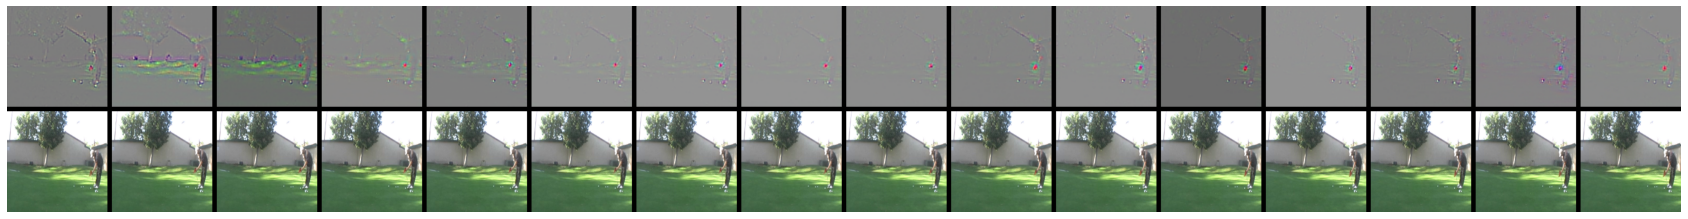

In [36]:
margin = 10
single_im_size = 224
frames = clip.size(0)

guided_grads_np = resize(guided_grads, (single_im_size, single_im_size))
guided_grads_np = guided_grads_np.permute(1, 0, 2, 3).numpy()

final_image = np.zeros((2 * single_im_size + margin, 
                        frames * single_im_size + margin * (frames - 1), 
                        3)).astype('uint8')
 
for i in range(frames):
    start_w = i * single_im_size + (margin * i)
    end_w = start_w + single_im_size

    grad_im = post_process_grad_im(guided_grads_np[i - 1])
    final_image[: single_im_size, start_w: end_w] = grad_im
    
    clip_im = Image.fromarray(clip[i - 1].numpy())
    clip_im = clip_im.resize((single_im_size, single_im_size))
    clip_im = np.array(clip_im)
    final_image[single_im_size + margin:, start_w: end_w] = clip_im

plt.figure(figsize=(30, 15))
plt.axis('off')
plt.imshow(final_image)
plt.show()

We observe a similar behaviour as the one described in the prviously mentioned C3D paper.

> Interestingly, C3D captures appearance for the first few frames but
thereafter only attends to salient motion.